In [1]:
import shapefile
import math
import json
import random
import shapely
import descartes
import tripy
import matplotlib.pyplot as plt
import alphashape as aps
import trimesh
from perlin_noise import PerlinNoise


sf = shapefile.Reader("./WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp")
shapeRecordNL = [sr for sr in sf.shapeRecords() if 'Netherlands' in sr.record[4]][-1]

In [3]:
points = shapeRecordNL.shape.points
parts = shapeRecordNL.shape.parts
n_parts = len(parts)
# draw center of bounding box in middle
x_norm = (shapeRecordNL.shape.bbox[0] + shapeRecordNL.shape.bbox[2]) / 2
z_norm = (shapeRecordNL.shape.bbox[1] + shapeRecordNL.shape.bbox[3]) / 2
bbox_normalized = [
    (shapeRecordNL.shape.bbox[0] - x_norm),
    (shapeRecordNL.shape.bbox[1] - z_norm),
    (shapeRecordNL.shape.bbox[2] - x_norm),
    (shapeRecordNL.shape.bbox[3] - z_norm),
]

n_points = len(points)


def rotate(point, angle):
    ox, oy = (0.0, 0.0)
    px, py = point
    cos = math.cos(angle)
    sin = math.sin(angle)
    qx = ox + cos * (px - ox) - sin * (py - oy)
    qy = oy + sin * (px - ox) + cos * (py - oy)
    return qx, qy


angle = 0  # fl
flip = -1  # the -1 is to flip the image on the north axis, it's more natural for three js
points = [rotate(((p[0] - x_norm) * flip, (p[1] - z_norm) * flip), math.radians(angle)) for p in points]

polygons = []
for i in range(len(parts)):
    start = parts[i]
    end = parts[i + 1] if i != (len(parts) - 1) else None
    polygon = shapely.geometry.Polygon(shapely.geometry.LinearRing(points[start:end]))
    polygons.append(polygon)

points = [(point[0], random.random() / 100, point[1]) for point in points]

columns = 64
rows = 64
is_contained = lambda point: any([p.contains(shapely.geometry.Point(point)) for p in polygons])
column_delta = (bbox_normalized[2] - bbox_normalized[0]) / columns
row_delta = (bbox_normalized[3] - bbox_normalized[1]) / rows

noise = PerlinNoise(octaves=1)
# todo could only calc noise for points actually contained dunno how long this takes
grid_points = [((bbox_normalized[0] + (x * column_delta)), abs(noise([x * column_delta, z * row_delta])), (bbox_normalized[1] + (z * row_delta)), (x), (z)) for x in
               range(columns) for z in range(rows)]

grid_points = [(point[0], point[1], point[2], point[3], point[4]) for point in grid_points if is_contained(point)]

points.extend(grid_points)

In [4]:
half_column_delta = column_delta / 2
half_row_delta = row_delta / 2

def create_cube(point):
    x_start = point[0] - half_column_delta
    y_start = 0.001
    z_start = point[2] - half_row_delta
    x_end = point[0] + half_column_delta
    y_end = point[1]
    z_end = point[2] + half_row_delta

    p1 = [
        x_start, y_start, z_start
    ]
    p2 = [
        x_start, y_start, z_end
    ]
    p3 = [
        x_start, y_end, z_start
    ]
    p4 = [
        x_end, y_start, z_start
    ]
    p5 = [
        x_start, y_end, z_end
    ]
    p6 = [
        x_end, y_end, z_start
    ]
    p7 = [
        x_end, y_start, z_end
    ]
    p8 = [
        x_end, y_end, z_end
    ]

    t1 = [
        p1, p4, p6
    ]
    t2 = [
        p1, p3, p6
    ]

    t3 = [
        p1, p2, p5
    ]
    t4 = [
        p1, p3, p5
    ]

    t5 = [  # these are the bottom triangles most likely
        p1, p4, p7
    ]
    t6 = [  # these are the bottom triangles most likely
        p1, p2, p7
    ]

    t7 = [
        p8, p2, p7
    ]

    t8 = [
        p8, p5, p2
    ]

    t9 = [
        p8, p6, p3
    ]

    t10 = [
        p8, p5, p3
    ]

    t11 = [
        p8, p7, p4
    ]

    t12 = [
        p8, p6, p4
    ]
    positions = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12]
    positions = [item for sublist in positions for item in sublist]
    positions = [item for sublist in positions for item in sublist]
    return positions
cubes_flat = [item for sublist in [create_cube(point) for point in points] for item in sublist]

In [5]:
import utils
for i, point in enumerate(grid_points):
    # print(f"{i} out of {len(grid_points)}")
    cubes_flat = create_cube(point)
    level = 0
    column = point[3]
    row = point[4]
    name= f"{(column * rows) + row}"
    path = f'../frontend/public/chunks/{name}_{level}.json'
    utils.store_as_json(cubes_flat, path)
    # print("wrote cubes")


In [24]:
l# points_per_part = []
# for i in range(len(parts)):
#     start = parts[i]
#     end = parts[i+1] if i != (len(parts) - 1) else None
#     points_per_part.append(points[start:end])
#
# def shapely_coords_to_flattened_positions(coords):
#     triangles_3d = [
#         (triangle[0], 0, triangle[1])
#         for triangle
#         in [
#             item
#             for sublist
#             in tripy.earclip(coords)
#             for item
#             in sublist
#         ]
#     ]
#     positions_flat = [item for sublist in triangles_3d for item in sublist]
#     return positions_flat
#
#
# def extract_positions(shape):
#     if isinstance(shape, shapely.geometry.polygon.Polygon):
#         positions_flat = shapely_coords_to_flattened_positions(shape.exterior.coords)
#     elif isinstance(shape, shapely.geometry.multipolygon.MultiPolygon):
#         positions_flat = []
#         [positions_flat.extend(shapely_coords_to_flattened_positions(p.exterior.coords)) for p in list(shape)]
#     elif isinstance(shape, trimesh.base.Trimesh):
#         positions_nested = [
#             shape.vertices[edge[0]]
#             for edge in
#             shape.edges
#         ]
#         positions_flat = [item.tolist() for sublist in positions_nested for item in sublist]
#     else:
#         raise ValueError(f"Received {shape} as shape; type {type(shape)} is not supported")
#     return positions_flat
#
# positions = []
# shapes = []
#
# for coordinates in points_per_part:
#     shape = aps.alphashape(coordinates, 2.0)
#     if isinstance(shape, shapely.geometry.collection.GeometryCollection):
#         continue
#     shapes.append(shape)
#     positions.extend(extract_positions(shape))
#
# # The borders seem kinda janky due to triangles that have two very long sides and one small side. These can for example be seen connecting the northern parts of the netherlands with the Wadden islands. This tries to delete these triangles by detecting long sides and removing them from the final output. Doesn't work very well though.
# # to_remove = []
# # threshold = 1.5
# #
# # # TODO use numpy to do this probably a lot faster
# # for i in range(0, len(positions)-9, 9):
# #     x1 = positions[i]
# #     # y1 = positions[i+1]
# #     z1 = positions[i+2]
# #
# #     x2 = positions[i+3]
# #     # y2 = positions[i+4]
# #     z2 = positions[i+5]
# #
# #     x3 = positions[i+6]
# #     # y3 = positions[i+7]
# #     z3 = positions[i+9]
# #
# #
# #     x12_dist = abs(x2-x1)
# #     x23_dist = abs(x3-x2)
# #     x31_dist = abs(x1-x3)
# #
# #     # y12_dist = abs(y2-y1)
# #     # y23_dist = abs(y3-y2)
# #     # y31_dist = abs(y1-y3)
# #
# #     z12_dist = abs(z2-z1)
# #     z23_dist = abs(z3-z2)
# #     z31_dist = abs(z1-x3)
# #
# #     # p12_dist_s1 = x12_dist + y12_dist
# #     # p12_dist_s2 = y12_dist + z12_dist
# #     # p12_dist_s3 = z12_dist + x12_dist
# #     #
# #     # p23_dist_s1 = x23_dist + y23_dist
# #     # p23_dist_s2 = y23_dist + z23_dist
# #     # p23_dist_s3 = z23_dist + x23_dist
# #     #
# #     # p31_dist_s1 = x31_dist + y31_dist
# #     # p31_dist_s2 = y31_dist + z31_dist
# #     # p31_dist_s3 = z31_dist + x31_dist
# #
# #     if any([(val > threshold) for val in [x12_dist, x23_dist, x31_dist, z12_dist, z23_dist, z31_dist]]):
# #     # if any([(val > threshold) for val in [p12_dist_s1, p12_dist_s2, p12_dist_s3, p23_dist_s1, p23_dist_s2, p23_dist_s3, p31_dist_s1, p31_dist_s2, p31_dist_s3]]):
# #
# #         to_remove.append(i)
# #
# # positions_filtered = []
# # for i in range(0, len(positions)-9, 9):
# #     if i in to_remove:
# #         continue
# #     positions_filtered.extend(positions[i:i+9])
# #
# # positions = positions_filtered
#
# r = lambda: random.randint(0, 255)
# geometry_type = 'random_sample'
# name = 'map_netherlands'
# color = f'#{r():02X}{r():02X}{r():02X}'
# geometry_data = {
#     'type': geometry_type,
#     'color': color,
#     'name': name,
#     'positions': positions,
# }
#
# filename = f'../frontend/src/mesh_data/{name}.json'
# with open(filename, 'w') as fp:
#     json.dump(geometry_data, fp)


/Users/hkstm/IdeaProjects/lsde2022-group02/env/lib/python3.8/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


TypeError: 'Trimesh' object is not subscriptable

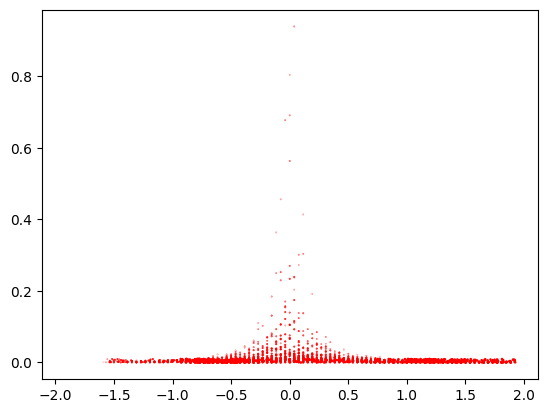

In [4]:
# fig, ax = plt.subplots()
# ax.scatter(*zip(*[item for sublist in points_per_part for item in sublist]), color='red')
# # for shape in shapes:
# #     ax.add_patch(descartes.PolygonPatch(shape, alpha=1.0, color=f'#{r():02X}{r():02X}{r():02X}'))
# plt.show()